# Track Embedding Analysis: CLIP Similarity Exploration

This notebook analyzes track embeddings using the **exact same Worker code** from your eval pipeline.

**Goal:** 
1. Pick one video sequence
2. Select 2 tracks
3. Compute average embeddings for each track
4. Compare to reference text embedding (text prompt)
5. Statistical analysis to find differences or exploits

In [1]:
import os
import sys
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd
from scipy import stats
from PIL import Image
import argparse

# Add parent directory to path
sys.path.insert(0, '..')
sys.path.insert(0, '../eval')

# Import your exact Worker code
from worker_clean import Worker

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

/isis/home/hasana3/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.1.2+cu121
CUDA available: True
CUDA device: NVIDIA RTX 6000 Ada Generation


## 1. Configuration

In [2]:
# === CONFIGURATION ===
SEQUENCE = "0001"  # Pick your sequence
TEXT_PROMPT = "black car on the right"  # Your referring expression

# Paths
DATA_ROOT = "../dataset/referkitti"
IMAGE_DIR = os.path.join(DATA_ROOT, "KITTI/training/image_02", SEQUENCE)
CONFIG_PATH = "../groundingdino/config/GroundingDINO_SwinB_cfg.py"
WEIGHTS_PATH = "../weights/swinb_light_visdrone_ft_best.pth"

# Detection parameters (same as your eval)
BOX_THRESHOLD = 0.40
TEXT_THRESHOLD = 0.80

# Tracking parameters (same as your eval)
TRACK_THRESH = 0.45
MATCH_THRESH = 0.85
TRACK_BUFFER = 120
LAMBDA_WEIGHT = 0.25
LOW_THRESH = 0.1
TEXT_SIM_THRESH = 0.0

# Device
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Tracker type: "clip" to use CLIP embeddings
TRACKER_TYPE = "clip"

print(f"Sequence: {SEQUENCE}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Text prompt: '{TEXT_PROMPT}'")
print(f"Device: {DEVICE}")
print(f"Tracker: {TRACKER_TYPE}")

Sequence: 0001
Image directory: ../dataset/referkitti/KITTI/training/image_02/0001
Text prompt: 'black car on the right'
Device: cuda:0
Tracker: clip


## 2. Initialize Worker (Using Your Exact Code)

In [3]:
# Build tracker kwargs (same as your eval_referkitti.py)
tracker_kwargs = dict(
    track_thresh=TRACK_THRESH,
    track_buffer=TRACK_BUFFER,
    match_thresh=MATCH_THRESH,
    lambda_weight=LAMBDA_WEIGHT,
    low_thresh=LOW_THRESH,
    text_sim_thresh=TEXT_SIM_THRESH,
    use_clip_in_high=False,
    use_clip_in_low=True,
    use_clip_in_unconf=True,
)

# Initialize Worker with your exact parameters
worker = Worker(
    tracker_type=TRACKER_TYPE,
    tracker_kwargs=tracker_kwargs,
    box_thresh=BOX_THRESHOLD,
    text_thresh=TEXT_THRESHOLD,
    use_fp16=False,
    text_prompt=TEXT_PROMPT,
    detector="dino",
    frame_rate=10,
    save_video=False,
    show_gt_boxes=False,
    dataset_type="referkitti",
    referkitti_data_root=DATA_ROOT,
    min_box_area=10,
    config_path=CONFIG_PATH,
    weights_path=WEIGHTS_PATH,
    device=DEVICE,
    referring_mode="none",  # No pre-filtering for analysis
)

print("✓ Worker initialized with exact eval_referkitti.py parameters")
print(f"  Text embedding shape: {worker.text_embedding.shape if worker.text_embedding is not None else 'None'}")
print(f"  CLIP model loaded: {worker.clip_model is not None}")

final text_encoder_type: bert-base-uncased
✓ Worker initialized with exact eval_referkitti.py parameters
  Text embedding shape: torch.Size([1, 512])
  CLIP model loaded: True


## 3. Run Tracking and Collect Embeddings

In [4]:
# Get frame list
frame_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png', '.jpg'))])
print(f"Found {len(frame_files)} frames")

# Storage for track embeddings
track_embeddings = defaultdict(list)  # track_id -> [embeddings]
track_frames = defaultdict(list)      # track_id -> [frame_ids]
track_boxes = defaultdict(list)       # track_id -> [tlbr boxes]

print("\nProcessing frames...")

Found 447 frames

Processing frames...


In [5]:
# Process each frame
for frame_idx, frame_file in enumerate(frame_files):
    if frame_idx % 10 == 0:
        print(f"  Frame {frame_idx}/{len(frame_files)}...")
    
    # Load frame
    img_path = os.path.join(IMAGE_DIR, frame_file)
    frame_bgr = cv2.imread(img_path)
    if frame_bgr is None:
        print(f"  ⚠ Could not read frame: {frame_file}")
        continue
    
    H, W = frame_bgr.shape[:2]
    
    # Preprocess frame (using Worker's exact method)
    tensor_image = worker.preprocess_frame(frame_bgr)
    
    # Run detection (using Worker's exact method)
    dets_xyxy = worker.predict_detections(frame_bgr, tensor_image, H, W)
    
    # Update tracker (using Worker's exact method)
    online_targets = worker.update_tracker_clip(dets_xyxy, frame_bgr, H, W)
    
    # Store track embeddings (these are already computed by Worker)
    for track in online_targets:
        if hasattr(track, 'embedding') and track.embedding is not None:
            track_embeddings[track.track_id].append(track.embedding.clone())
            track_frames[track.track_id].append(frame_idx)
            track_boxes[track.track_id].append(track.tlbr.copy())

print(f"\n✓ Tracking complete!")
print(f"  Total unique tracks: {len(track_embeddings)}")

  Frame 0/447...


  Frame 10/447...
  Frame 20/447...
  Frame 30/447...
  Frame 40/447...
  Frame 50/447...
  Frame 60/447...
  Frame 70/447...
  Frame 80/447...
  Frame 90/447...
  Frame 100/447...
  Frame 110/447...
  Frame 120/447...
  Frame 130/447...
  Frame 140/447...
  Frame 150/447...
  Frame 160/447...
  Frame 170/447...
  Frame 180/447...
  Frame 190/447...
  Frame 200/447...
  Frame 210/447...
  Frame 220/447...
  Frame 230/447...
  Frame 240/447...
  Frame 250/447...
  Frame 260/447...
  Frame 270/447...
  Frame 280/447...
  Frame 290/447...
  Frame 300/447...
  Frame 310/447...
  Frame 320/447...
  Frame 330/447...
  Frame 340/447...
  Frame 350/447...
  Frame 360/447...
  Frame 370/447...
  Frame 380/447...
  Frame 390/447...
  Frame 400/447...
  Frame 410/447...
  Frame 420/447...
  Frame 430/447...
  Frame 440/447...

✓ Tracking complete!
  Total unique tracks: 39


## 4. Select 2 Tracks for Analysis

In [6]:
# Show available tracks
track_info = []
for track_id, embeddings in track_embeddings.items():
    track_info.append({
        'track_id': track_id,
        'num_embeddings': len(embeddings),
        'first_frame': min(track_frames[track_id]),
        'last_frame': max(track_frames[track_id])
    })

df_tracks = pd.DataFrame(track_info).sort_values('num_embeddings', ascending=False)
print("\nAvailable tracks (sorted by length):")
print(df_tracks.to_string(index=False))

# Auto-select the two longest tracks
if len(df_tracks) >= 2:
    TRACK_ID_1 = int(df_tracks.iloc[0]['track_id'])
    TRACK_ID_2 = int(df_tracks.iloc[1]['track_id'])
    print(f"\n✓ Auto-selected tracks: {TRACK_ID_1} and {TRACK_ID_2}")
    print(f"  Track {TRACK_ID_1}: {len(track_embeddings[TRACK_ID_1])} embeddings")
    print(f"  Track {TRACK_ID_2}: {len(track_embeddings[TRACK_ID_2])} embeddings")
else:
    print("\n⚠ Not enough tracks found! Need at least 2 tracks.")
    TRACK_ID_1 = None
    TRACK_ID_2 = None


Available tracks (sorted by length):
 track_id  num_embeddings  first_frame  last_frame
       36              36          351         388
       35              36          350         407
       22              33          160         192
       23              33          202         234
       28              26          270         295
       41              26          400         426
        5              26           18          43
        8              21           54          74
       33              20          327         346
        6              18           30          47
       13              16           88         103
       18              14          137         150
       25              14          247         260
       21              13          157         169
       29              13          294         306
       17              12          124         135
       26              12          255         266
       14              11          104      

## 5. Compute Average Embeddings per Track

In [7]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Stack embeddings for each track
    embeddings_track1 = torch.stack(track_embeddings[TRACK_ID_1])
    embeddings_track2 = torch.stack(track_embeddings[TRACK_ID_2])
    
    # Compute average embeddings
    avg_embedding_track1 = embeddings_track1.mean(dim=0)
    avg_embedding_track2 = embeddings_track2.mean(dim=0)
    
    # Normalize (important for cosine similarity)
    avg_embedding_track1 = avg_embedding_track1 / (avg_embedding_track1.norm() + 1e-6)
    avg_embedding_track2 = avg_embedding_track2 / (avg_embedding_track2.norm() + 1e-6)
    
    print(f"\nTrack {TRACK_ID_1}:")
    print(f"  Shape: {avg_embedding_track1.shape}")
    print(f"  Norm: {avg_embedding_track1.norm().item():.6f}")
    
    print(f"\nTrack {TRACK_ID_2}:")
    print(f"  Shape: {avg_embedding_track2.shape}")
    print(f"  Norm: {avg_embedding_track2.norm().item():.6f}")


Track 36:
  Shape: torch.Size([512])
  Norm: 0.999999

Track 35:
  Shape: torch.Size([512])
  Norm: 0.999999


## 6. Get Reference Text Embedding

Use the **exact same text embedding** that Worker computed.

In [8]:
# Get reference text embedding (already computed by Worker)
reference_embedding = worker.text_embedding[0].cpu()  # First class

print(f"Reference text embedding:")
print(f"  Text prompt: '{TEXT_PROMPT}'")
print(f"  Class names parsed: {worker.class_names}")
print(f"  Shape: {reference_embedding.shape}")
print(f"  Norm: {reference_embedding.norm().item():.6f}")

Reference text embedding:
  Text prompt: 'black car on the right'
  Class names parsed: ['black car on the right']
  Shape: torch.Size([512])
  Norm: 1.000000


## 7. Compute Cosine Similarities

In [9]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Cosine similarity: average track embedding → text embedding
    sim_track1_to_text = F.cosine_similarity(
        avg_embedding_track1.unsqueeze(0),
        reference_embedding.unsqueeze(0)
    ).item()
    
    sim_track2_to_text = F.cosine_similarity(
        avg_embedding_track2.unsqueeze(0),
        reference_embedding.unsqueeze(0)
    ).item()
    
    # Cosine similarity: track1 → track2
    sim_track1_to_track2 = F.cosine_similarity(
        avg_embedding_track1.unsqueeze(0),
        avg_embedding_track2.unsqueeze(0)
    ).item()
    
    print("\n" + "="*70)
    print("COSINE SIMILARITY RESULTS (Average Embeddings)")
    print("="*70)
    print(f"Track {TRACK_ID_1} → Text:        {sim_track1_to_text:.4f}")
    print(f"Track {TRACK_ID_2} → Text:        {sim_track2_to_text:.4f}")
    print(f"Track {TRACK_ID_1} → Track {TRACK_ID_2}:   {sim_track1_to_track2:.4f}")
    print(f"\nDifference in text similarity:")
    print(f"  Δ = {abs(sim_track1_to_text - sim_track2_to_text):.4f}")
    
    if sim_track1_to_text > sim_track2_to_text:
        print(f"  → Track {TRACK_ID_1} is MORE similar to text")
    else:
        print(f"  → Track {TRACK_ID_2} is MORE similar to text")
    print("="*70)


COSINE SIMILARITY RESULTS (Average Embeddings)
Track 36 → Text:        0.2737
Track 35 → Text:        0.2652
Track 36 → Track 35:   0.9724

Difference in text similarity:
  Δ = 0.0085
  → Track 36 is MORE similar to text


## 8. Per-Frame Similarity Analysis

In [10]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Compute per-frame similarities to text
    sims_track1 = []
    for emb in embeddings_track1:
        sim = F.cosine_similarity(emb.unsqueeze(0), reference_embedding.unsqueeze(0)).item()
        sims_track1.append(sim)
    
    sims_track2 = []
    for emb in embeddings_track2:
        sim = F.cosine_similarity(emb.unsqueeze(0), reference_embedding.unsqueeze(0)).item()
        sims_track2.append(sim)
    
    # Convert to numpy
    sims_track1 = np.array(sims_track1)
    sims_track2 = np.array(sims_track2)
    
    print("\n" + "="*70)
    print(f"PER-FRAME SIMILARITY STATISTICS (Track → Text)")
    print("="*70)
    
    print(f"\nTrack {TRACK_ID_1}:")
    print(f"  Mean:   {sims_track1.mean():.4f}")
    print(f"  Std:    {sims_track1.std():.4f}")
    print(f"  Min:    {sims_track1.min():.4f}")
    print(f"  Max:    {sims_track1.max():.4f}")
    print(f"  Median: {np.median(sims_track1):.4f}")
    
    print(f"\nTrack {TRACK_ID_2}:")
    print(f"  Mean:   {sims_track2.mean():.4f}")
    print(f"  Std:    {sims_track2.std():.4f}")
    print(f"  Min:    {sims_track2.min():.4f}")
    print(f"  Max:    {sims_track2.max():.4f}")
    print(f"  Median: {np.median(sims_track2):.4f}")


PER-FRAME SIMILARITY STATISTICS (Track → Text)

Track 36:
  Mean:   0.2692
  Std:    0.0027
  Min:    0.2650
  Max:    0.2752
  Median: 0.2688

Track 35:
  Mean:   0.2619
  Std:    0.0036
  Min:    0.2570
  Max:    0.2706
  Median: 0.2611


## 9. Statistical Significance Testing

In [11]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Two-sample t-test
    t_stat, p_value = stats.ttest_ind(sims_track1, sims_track2)
    
    print(f"\n" + "="*70)
    print("STATISTICAL SIGNIFICANCE TEST")
    print("="*70)
    print(f"Test: Two-sample t-test")
    print(f"H0: The two tracks have the same mean similarity to text\n")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value:     {p_value:.6f}")
    
    alpha = 0.05
    if p_value < alpha:
        print(f"\n✓ SIGNIFICANT DIFFERENCE (p < {alpha})")
        print(f"  We can reject the null hypothesis.")
        print(f"  The two tracks have statistically different similarities to text.")
    else:
        print(f"\n✗ NO SIGNIFICANT DIFFERENCE (p >= {alpha})")
        print(f"  We cannot reject the null hypothesis.")
        print(f"  The two tracks have similar similarities to text.")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(
        ((len(sims_track1)-1) * sims_track1.std()**2 + 
         (len(sims_track2)-1) * sims_track2.std()**2) / 
        (len(sims_track1) + len(sims_track2) - 2)
    )
    cohens_d = (sims_track1.mean() - sims_track2.mean()) / pooled_std
    
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
    if abs(cohens_d) < 0.2:
        print("  → Small effect")
    elif abs(cohens_d) < 0.5:
        print("  → Medium effect")
    else:
        print("  → Large effect")
    
    # Mann-Whitney U test (non-parametric alternative)
    u_stat, u_pvalue = stats.mannwhitneyu(sims_track1, sims_track2, alternative='two-sided')
    print(f"\nMann-Whitney U test (non-parametric):")
    print(f"  U-statistic: {u_stat:.4f}")
    print(f"  P-value:     {u_pvalue:.6f}")
    
    print("="*70)


STATISTICAL SIGNIFICANCE TEST
Test: Two-sample t-test
H0: The two tracks have the same mean similarity to text

T-statistic: 9.4276
P-value:     0.000000

✓ SIGNIFICANT DIFFERENCE (p < 0.05)
  We can reject the null hypothesis.
  The two tracks have statistically different similarities to text.

Effect size (Cohen's d): 2.2536
  → Large effect

Mann-Whitney U test (non-parametric):
  U-statistic: 1167.0000
  P-value:     0.000000


## 10. Visualization: Distributions

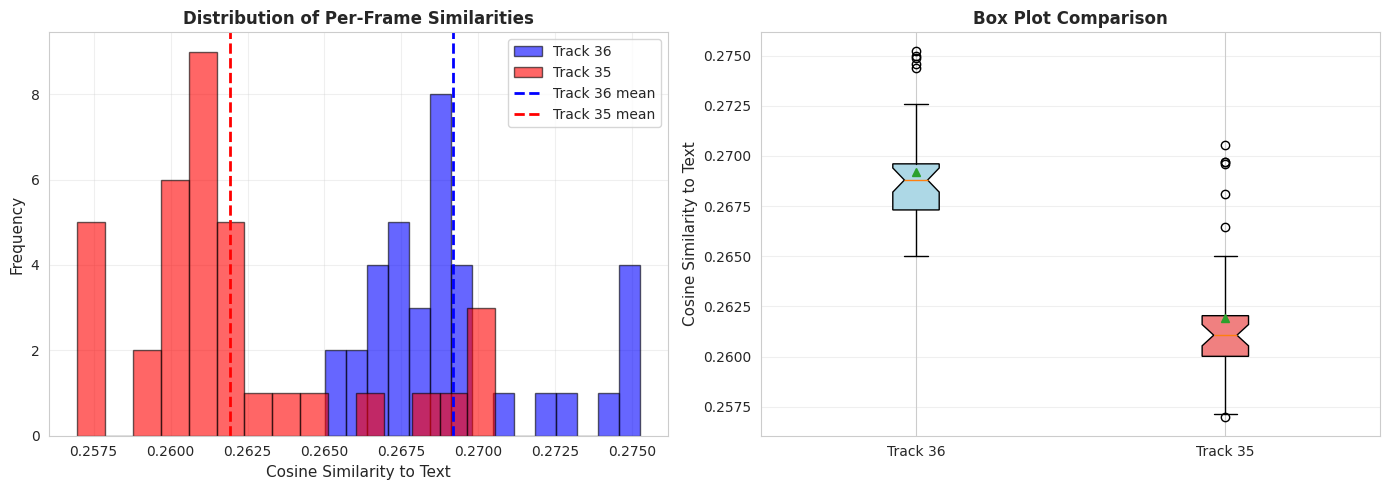

In [12]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(sims_track1, bins=15, alpha=0.6, label=f'Track {TRACK_ID_1}', 
                 color='blue', edgecolor='black')
    axes[0].hist(sims_track2, bins=15, alpha=0.6, label=f'Track {TRACK_ID_2}', 
                 color='red', edgecolor='black')
    axes[0].axvline(sims_track1.mean(), color='blue', linestyle='--', linewidth=2, 
                    label=f'Track {TRACK_ID_1} mean')
    axes[0].axvline(sims_track2.mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Track {TRACK_ID_2} mean')
    axes[0].set_xlabel('Cosine Similarity to Text', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Distribution of Per-Frame Similarities', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    data_for_box = [sims_track1, sims_track2]
    bp = axes[1].boxplot(data_for_box, 
                         labels=[f'Track {TRACK_ID_1}', f'Track {TRACK_ID_2}'],
                         patch_artist=True, notch=True, showmeans=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    axes[1].set_ylabel('Cosine Similarity to Text', fontsize=11)
    axes[1].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 11. Temporal Evolution

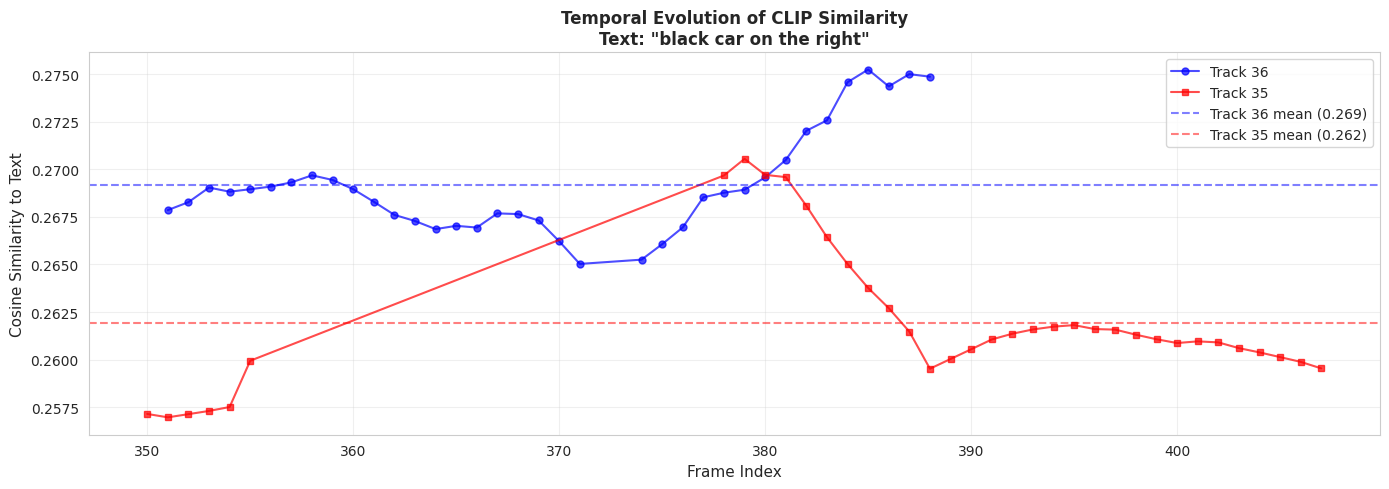

In [13]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Plot similarity over frames
    ax.plot(track_frames[TRACK_ID_1], sims_track1, 'o-', 
            label=f'Track {TRACK_ID_1}', color='blue', alpha=0.7, markersize=5)
    ax.plot(track_frames[TRACK_ID_2], sims_track2, 's-', 
            label=f'Track {TRACK_ID_2}', color='red', alpha=0.7, markersize=5)
    
    # Add mean lines
    ax.axhline(sims_track1.mean(), color='blue', linestyle='--', alpha=0.5, 
               label=f'Track {TRACK_ID_1} mean ({sims_track1.mean():.3f})')
    ax.axhline(sims_track2.mean(), color='red', linestyle='--', alpha=0.5, 
               label=f'Track {TRACK_ID_2} mean ({sims_track2.mean():.3f})')
    
    ax.set_xlabel('Frame Index', fontsize=11)
    ax.set_ylabel('Cosine Similarity to Text', fontsize=11)
    ax.set_title(f'Temporal Evolution of CLIP Similarity\nText: "{TEXT_PROMPT}"', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 12. CLIP Exploit Analysis: Test Different Prompts

In [14]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Test multiple text prompts
    test_prompts = [
        TEXT_PROMPT,
        "a vehicle",
        "a car",
        "a black car",
        "a white car",
        "car on the left",
        "car on the right",
        "person walking",
        "traffic on road",
        "object in scene",
        "vehicle in the middle",
        "dark colored vehicle"
    ]
    
    results = []
    
    with torch.no_grad():
        for prompt in test_prompts:
            # Encode prompt using Worker's exact method
            import clip
            text_tokens = clip.tokenize([prompt]).to(DEVICE)
            text_emb = worker.clip_model.encode_text(text_tokens)
            text_emb = F.normalize(text_emb.float(), dim=-1).cpu()[0]
            
            # Compute similarities
            sim1 = F.cosine_similarity(
                avg_embedding_track1.unsqueeze(0),
                text_emb.unsqueeze(0)
            ).item()
            
            sim2 = F.cosine_similarity(
                avg_embedding_track2.unsqueeze(0),
                text_emb.unsqueeze(0)
            ).item()
            
            results.append({
                'prompt': prompt,
                f'track_{TRACK_ID_1}': f"{sim1:.4f}",
                f'track_{TRACK_ID_2}': f"{sim2:.4f}",
                'difference': abs(sim1 - sim2),
                'avg_sim': (sim1 + sim2) / 2,
                'sim1_raw': sim1,
                'sim2_raw': sim2
            })
    
    df_results = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("PROMPT SENSITIVITY ANALYSIS")
    print("="*80)
    print(df_results[['prompt', f'track_{TRACK_ID_1}', f'track_{TRACK_ID_2}', 'difference']].to_string(index=False))
    print("="*80)
    
    # Find interesting prompts
    best_avg_idx = df_results['avg_sim'].idxmax()
    print(f"\n✓ Prompt with HIGHEST average similarity:")
    print(f"  '{df_results.loc[best_avg_idx, 'prompt']}'")
    print(f"  Avg: {df_results.loc[best_avg_idx, 'avg_sim']:.4f}")
    
    largest_diff_idx = df_results['difference'].idxmax()
    print(f"\n✓ Prompt with LARGEST discrimination:")
    print(f"  '{df_results.loc[largest_diff_idx, 'prompt']}'")
    print(f"  Difference: {df_results.loc[largest_diff_idx, 'difference']:.4f}")
    print(f"  Track {TRACK_ID_1}: {df_results.loc[largest_diff_idx, 'sim1_raw']:.4f}")
    print(f"  Track {TRACK_ID_2}: {df_results.loc[largest_diff_idx, 'sim2_raw']:.4f}")


PROMPT SENSITIVITY ANALYSIS
                prompt track_36 track_35  difference
black car on the right   0.2737   0.2652    0.008540
             a vehicle   0.2782   0.2751    0.003149
                 a car   0.2726   0.2676    0.005037
           a black car   0.2741   0.2721    0.001948
           a white car   0.2693   0.2627    0.006603
       car on the left   0.2753   0.2677    0.007675
      car on the right   0.2729   0.2654    0.007484
        person walking   0.2682   0.2758    0.007609
       traffic on road   0.2619   0.2599    0.001916
       object in scene   0.2748   0.2817    0.006960
 vehicle in the middle   0.2813   0.2798    0.001428
  dark colored vehicle   0.2849   0.2826    0.002369

✓ Prompt with HIGHEST average similarity:
  'dark colored vehicle'
  Avg: 0.2838

✓ Prompt with LARGEST discrimination:
  'black car on the right'
  Difference: 0.0085
  Track 36: 0.2737
  Track 35: 0.2652


## 13. Heatmap Visualization

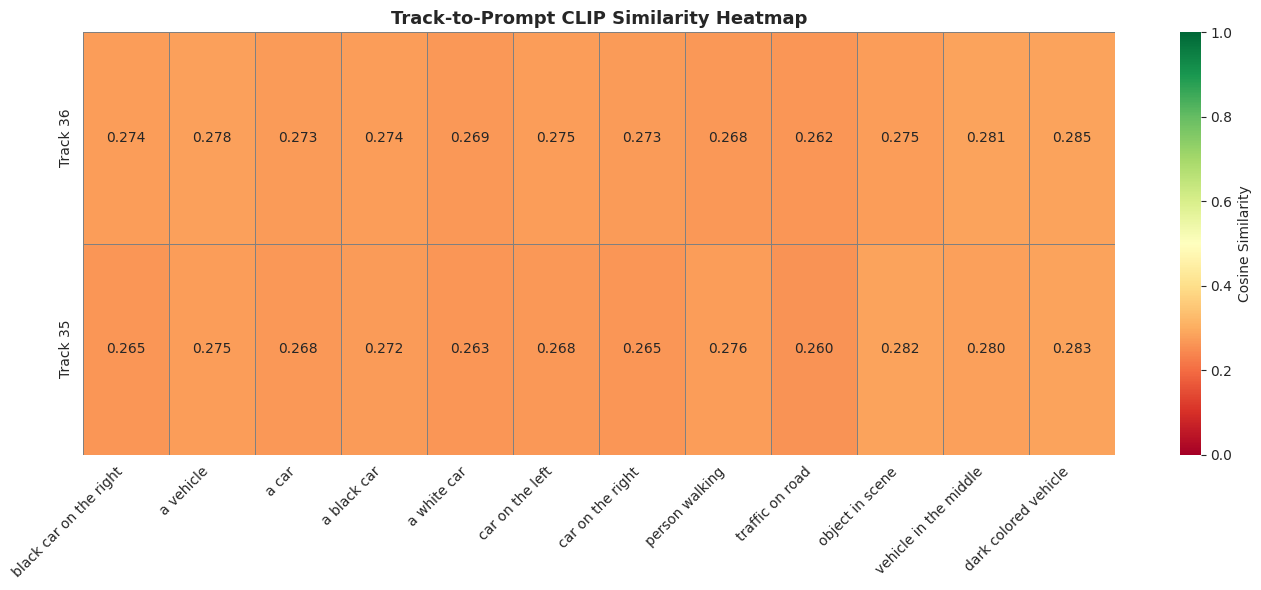

In [15]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Create similarity matrix
    similarity_matrix = np.array([
        df_results['sim1_raw'].values,
        df_results['sim2_raw'].values
    ])
    
    plt.figure(figsize=(14, 6))
    sns.heatmap(similarity_matrix, 
                xticklabels=df_results['prompt'].values,
                yticklabels=[f'Track {TRACK_ID_1}', f'Track {TRACK_ID_2}'],
                annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                cbar_kws={'label': 'Cosine Similarity'},
                linewidths=0.5, linecolor='gray')
    plt.title('Track-to-Prompt CLIP Similarity Heatmap', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 14. Exploit Discovery: Findings Summary

In [16]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    print("\n" + "="*80)
    print("KEY FINDINGS & POTENTIAL EXPLOITS")
    print("="*80)
    
    print(f"\n1. STATISTICAL DIFFERENCE:")
    if p_value < 0.05:
        print(f"   ✓ Significant difference found (p={p_value:.6f})")
        print(f"   → Tracks are distinguishable by CLIP embeddings")
    else:
        print(f"   ✗ No significant difference (p={p_value:.6f})")
        print(f"   → Tracks may be visually similar or CLIP cannot distinguish them")
    
    print(f"\n2. EFFECT SIZE:")
    print(f"   Cohen's d = {cohens_d:.4f}")
    if abs(cohens_d) > 0.5:
        print(f"   → Large effect: embeddings are substantially different")
    else:
        print(f"   → Small/medium effect: embeddings are somewhat similar")
    
    print(f"\n3. TEMPORAL STABILITY:")
    track1_std = sims_track1.std()
    track2_std = sims_track2.std()
    print(f"   Track {TRACK_ID_1} std: {track1_std:.4f}")
    print(f"   Track {TRACK_ID_2} std: {track2_std:.4f}")
    if max(track1_std, track2_std) > 0.1:
        print(f"   → High variance: similarity changes significantly over time")
        print(f"   → POTENTIAL EXPLOIT: Temporal drift could be exploited")
    else:
        print(f"   → Low variance: embeddings are stable over time")
    
    print(f"\n4. PROMPT SENSITIVITY:")
    max_diff = df_results['difference'].max()
    min_diff = df_results['difference'].min()
    print(f"   Max difference across prompts: {max_diff:.4f}")
    print(f"   Min difference across prompts: {min_diff:.4f}")
    if max_diff > 0.2:
        print(f"   → High sensitivity: choice of prompt matters significantly")
        print(f"   → POTENTIAL EXPLOIT: Adversarial prompts could maximize/minimize similarity")
    
    print(f"\n5. CROSS-TRACK SIMILARITY:")
    print(f"   Track {TRACK_ID_1} ↔ Track {TRACK_ID_2}: {sim_track1_to_track2:.4f}")
    if sim_track1_to_track2 > 0.9:
        print(f"   → Very high similarity: tracks may be confused")
        print(f"   → POTENTIAL EXPLOIT: CLIP may fail to distinguish these tracks")
    elif sim_track1_to_track2 < 0.5:
        print(f"   → Low similarity: tracks are well separated in embedding space")
    
    print("\n" + "="*80)
    print("RECOMMENDED NEXT STEPS:")
    print("="*80)
    print("1. Test with more track pairs to validate findings")
    print("2. Explore adversarial text prompts that maximize confusion")
    print("3. Analyze embedding space geometry (t-SNE, PCA)")
    print("4. Test threshold sensitivity for text_sim_thresh parameter")
    print("5. Compare different CLIP models (ViT-B/32 vs ViT-L/14)")
    print("="*80)


KEY FINDINGS & POTENTIAL EXPLOITS

1. STATISTICAL DIFFERENCE:
   ✓ Significant difference found (p=0.000000)
   → Tracks are distinguishable by CLIP embeddings

2. EFFECT SIZE:
   Cohen's d = 2.2536
   → Large effect: embeddings are substantially different

3. TEMPORAL STABILITY:
   Track 36 std: 0.0027
   Track 35 std: 0.0036
   → Low variance: embeddings are stable over time

4. PROMPT SENSITIVITY:
   Max difference across prompts: 0.0085
   Min difference across prompts: 0.0014

5. CROSS-TRACK SIMILARITY:
   Track 36 ↔ Track 35: 0.9724
   → Very high similarity: tracks may be confused
   → POTENTIAL EXPLOIT: CLIP may fail to distinguish these tracks

RECOMMENDED NEXT STEPS:
1. Test with more track pairs to validate findings
2. Explore adversarial text prompts that maximize confusion
3. Analyze embedding space geometry (t-SNE, PCA)
4. Test threshold sensitivity for text_sim_thresh parameter
5. Compare different CLIP models (ViT-B/32 vs ViT-L/14)


## 15. Export Results

In [17]:
if TRACK_ID_1 is not None and TRACK_ID_2 is not None:
    # Save summary
    summary = {
        'sequence': SEQUENCE,
        'text_prompt': TEXT_PROMPT,
        'track_1_id': TRACK_ID_1,
        'track_2_id': TRACK_ID_2,
        'track_1_frames': len(track_embeddings[TRACK_ID_1]),
        'track_2_frames': len(track_embeddings[TRACK_ID_2]),
        'avg_sim_track1_to_text': sim_track1_to_text,
        'avg_sim_track2_to_text': sim_track2_to_text,
        'sim_track1_to_track2': sim_track1_to_track2,
        'mean_track1': sims_track1.mean(),
        'mean_track2': sims_track2.mean(),
        'std_track1': sims_track1.std(),
        'std_track2': sims_track2.std(),
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05
    }
    
    print("\n" + "="*80)
    print("SUMMARY REPORT")
    print("="*80)
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"{key:30s}: {value:.6f}")
        else:
            print(f"{key:30s}: {value}")
    print("="*80)
    
    # Save to file
    import json
    output_file = f"track_analysis_{SEQUENCE}_{TRACK_ID_1}_vs_{TRACK_ID_2}.json"
    with open(output_file, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"\n✓ Results saved to: {output_file}")


SUMMARY REPORT
sequence                      : 0001
text_prompt                   : black car on the right
track_1_id                    : 36
track_2_id                    : 35
track_1_frames                : 36
track_2_frames                : 36
avg_sim_track1_to_text        : 0.273713
avg_sim_track2_to_text        : 0.265172
sim_track1_to_track2          : 0.972407
mean_track1                   : 0.269182
mean_track2                   : 0.261930
std_track1                    : 0.002740
std_track2                    : 0.003633
t_statistic                   : 9.427595
p_value                       : 0.000000
cohens_d                      : 2.253626
significant                   : True


TypeError: Object of type bool_ is not JSON serializable